In [73]:
import flappy_bird_gymnasium
import gymnasium as gym
import collections
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import csv

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Hyperparameters
learning_rate = 0.001
gamma         = 0.98
buffer_limit  = 50000
batch_size    = 64
render_mode=None
# render_mode='human'

env = gym.make("FlappyBird-v0", audio_on=bool(render_mode), render_mode=render_mode, use_lidar=False)

In [74]:
class ReplayBuffer():
    def __init__(self):
        self.buffer = collections.deque(maxlen=buffer_limit)

    def put(self, transition):
        self.buffer.append(transition)

    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst = np.zeros((n, len(mini_batch[0][0])))
        a_lst = np.zeros((n, 1))
        r_lst = np.zeros((n, 1))
        s_prime_lst = np.zeros((n, len(mini_batch[0][3])))
        done_mask_lst = np.zeros((n, 1))

        for i, transition in enumerate(mini_batch):
            s, a, r, s_prime, done_mask = transition
            s_lst[i] = s
            a_lst[i] = a
            r_lst[i] = r
            s_prime_lst[i] = s_prime
            done_mask_lst[i] = done_mask

        return torch.tensor(s_lst, dtype=torch.float).to(device), \
               torch.tensor(a_lst, dtype=torch.float).to(device), \
               torch.tensor(r_lst, dtype=torch.float).to(device), \
               torch.tensor(s_prime_lst, dtype=torch.float).to(device), \
               torch.tensor(done_mask_lst, dtype=torch.float).to(device)

    def size(self):
        return len(self.buffer)

class Qnet(nn.Module):
    def __init__(self):
        super(Qnet, self).__init__()
        self.fc1 = nn.Linear(12, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 2)
        self.dropout = nn.Dropout(0.2)  # Dropout layer for regularization

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout
        x = F.relu(self.fc2(x))
        x = self.dropout(x)  # Apply dropout
        x = self.fc3(x)
        return x

    def sample_action(self, obs, epsilon):
        out = self.forward(obs)
        coin = random.random()
        if coin < epsilon:
            return 0 if random.random() < 0.7 else 1  # more likely to wait
        else:
            return out.argmax().item()

def train(q, q_target, memory, optimizer):
    for i in range(10):
        s, a, r, s_prime, done_mask = memory.sample(batch_size)

        q_out = q(s)
        q_a = q_out.gather(1, a.long())
        max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1)
        target = r + gamma * max_q_prime * done_mask
        loss = F.smooth_l1_loss(q_a, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
def epsilon_schedule(episode):
    if episode <= 500:
        return max(0.08, 0.8 - 0.72 * (episode / 500))  # Linear decay from 80% to 8% over 500 episodes
    else:
        return max(0.005, 0.08 - 0.075 * ((episode - 500) / 9500))  # Linear decay from 8% to 1% over remaining episodes
    
    # return (0.5 - 0.5 * (episode / 10000)) if episode < 10000 else 0


In [75]:
def save_model(q, save_path):
    torch.save(q.state_dict(), save_path)
    print(f"Model saved to {save_path}")

In [76]:
def DQN(n_episode):
    q = Qnet().to(device)
    q.load_state_dict(torch.load('model_dqn_.pt'))
    q_target = Qnet().to(device)

    _learning_rate = learning_rate
    q_target.load_state_dict(q.state_dict())
    memory = ReplayBuffer()

    if render_mode == 'human':
        print_interval = 1
    else:
        print_interval = 1
    
    score = 0.0
    best_score=0
    optimizer = optim.AdamW(q.parameters(), lr=_learning_rate)

    # Open a file to save the results
    with open('training_log.csv', mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['n_episode', 'score'])

        for n_epi in range(n_episode+1):
            epsilon = epsilon_schedule(n_epi)
            s, _ = env.reset()

            while True:
                a = q.sample_action(torch.from_numpy(s).float().to(device), epsilon)
                s_prime, r, terminated, truncated, info = env.step(a)
                done = terminated or truncated
                done_mask = 0.0 if done else 1.0
                memory.put((s, a, r / 100.0, s_prime, done_mask))
                s = s_prime

                score += r
                if done:
                    break

            
                
            if n_epi % 20 == 0 and n_epi != 0:
                q_target.load_state_dict(q.state_dict())

            if n_epi % print_interval == 0 and n_epi != 0:
                
                print("n_episode :{}, score : {:.1f}, n_buffer : {}, eps : {:.1f}%".format(
                    n_epi, score / print_interval, memory.size(), epsilon * 100))
                writer.writerow([n_epi, score / print_interval])  # Save the results to the file
                
                # save best model
                if score / print_interval > best_score:
                    best_score = score / print_interval
                    save_model(q, f'./model2/model_dqn_{n_epi}.pt')
                score = 0.0
                
            if memory.size() > 2000:
                train(q, q_target, memory, optimizer)
                    
        env.close()


In [78]:
DQN(20000)

n_episode :1, score : -10.2, n_buffer : 100, eps : 79.9%
n_episode :2, score : -8.1, n_buffer : 150, eps : 79.7%
n_episode :3, score : -4.5, n_buffer : 200, eps : 79.6%
n_episode :4, score : -5.1, n_buffer : 250, eps : 79.4%
n_episode :5, score : -6.9, n_buffer : 300, eps : 79.3%
n_episode :6, score : -5.1, n_buffer : 350, eps : 79.1%
n_episode :7, score : -0.9, n_buffer : 400, eps : 79.0%
n_episode :8, score : -6.9, n_buffer : 450, eps : 78.8%
n_episode :9, score : -5.1, n_buffer : 500, eps : 78.7%
n_episode :10, score : -6.9, n_buffer : 550, eps : 78.6%
n_episode :11, score : -5.7, n_buffer : 600, eps : 78.4%
n_episode :12, score : 3.9, n_buffer : 650, eps : 78.3%
Model saved to ./model2/model_dqn_12.pt
n_episode :13, score : -4.5, n_buffer : 700, eps : 78.1%
n_episode :14, score : -6.3, n_buffer : 750, eps : 78.0%
n_episode :15, score : -5.7, n_buffer : 800, eps : 77.8%
n_episode :16, score : -6.9, n_buffer : 850, eps : 77.7%
n_episode :17, score : -2.7, n_buffer : 900, eps : 77.6%


In [103]:
import flappy_bird_gymnasium
env_human = gym.make("FlappyBird-v0", audio_on=True, render_mode='human', use_lidar=False)

def DQN_eval(model):
    q = Qnet().to(device)
    q.load_state_dict(torch.load(model))
    score = 0.0
    try:
        while True:
            s, _ = env_human.reset()
            while True:
                a = q.sample_action(torch.from_numpy(s).float().to(device),0)
                s, r, terminated, truncated, info = env_human.step(a)
                done = terminated or truncated
                score += r
                if done:
                    break
            print(f'{score:.1f}')
            score = 0.0
            

    except KeyboardInterrupt:
        env_human.close()
        
DQN_eval('./model2/model_dqn_15858.pt')

3.9
15.5
3.9
3.9
8.4
17.9
3.9
3.9
3.9
3.9
18.2
9.4
12.9
3.9
3.9
8.4
13.0
3.9
12.9
3.9
3.9
17.9
3.9
3.9
6.5
3.9
3.9
11.1
3.9
8.4
3.9
12.9
3.9
3.9
6.4
3.9
3.9
3.9
3.9
3.9
3.9
3.9
13.8
12.9
3.9
3.9
9.5
3.9
3.9
3.9
3.9
3.9
9.2
37.0
3.9
3.9
3.9
11.2
13.0
13.0
3.9
18.0
3.9
17.9
3.9
8.5
3.9
15.6
27.6
3.9
3.9
8.4
13.3
22.7
27.9
3.9
3.9
3.9
3.9
13.1
18.2
12.9
3.9
3.9
12.9
3.9
3.9
3.9
17.9
3.9
3.9
3.9
8.4
9.0
20.5
3.9
3.9
9.1
3.9
3.9
3.9
8.4
22.5
3.9
3.9
6.6
3.9
20.8
3.9
3.9
8.4
12.9
8.7
11.2
8.8
3.9
13.4
13.4
18.4
3.9
11.1
3.9
3.9
6.6
12.9
11.2
3.9
37.4
23.3
34.8
3.9
3.9
3.9
3.9
8.4
24.6
3.9
8.6
18.7
8.4
12.9
3.9
26.9
12.9
3.9
3.9
3.9
15.7
3.9
12.9
13.0
41.2
3.9
3.9
9.0
3.9
8.4
3.9
8.4
15.0
8.4
39.3
11.3
17.9
3.9
3.9
3.9
3.9
8.4
22.5
3.9
26.9
8.7
8.7
11.3
12.9
3.9
6.5
3.9
3.9
8.4
3.9
13.6
3.9
3.9
3.9
3.9
12.9
12.9
3.9
3.9
3.9
3.9
29.1
3.9
3.9
3.9
3.9
8.4
8.4
26.9
9.1
3.9
40.9
3.9
22.4
13.4
36.4
17.9
12.9
3.9
36.4
3.9
3.9
18.0
3.9
8.8
26.9
6.2
3.9
3.9
3.9
12.9
3.9
3.9
8.4
3.9
22.4
3.9
8.4
10.7


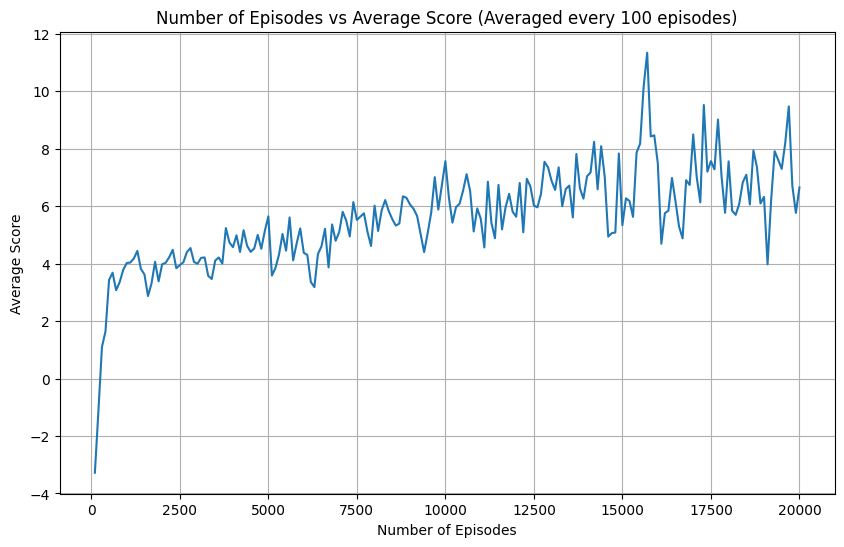

In [89]:
import csv
import matplotlib.pyplot as plt

# Function to read and parse the CSV file and compute average scores every N episodes
def parse_csv_and_average(file_path, N):
    n_episodes = []
    avg_scores = []
    
    with open(file_path, 'r') as csv_file:
        reader = csv.DictReader(csv_file)
        scores = []
        episode_count = 0
        for row in reader:
            episode_count += 1
            scores.append(float(row['score']))
            if episode_count % N == 0:
                avg_score = sum(scores) / N
                n_episodes.append(episode_count)
                avg_scores.append(avg_score)
                scores = []
    
    # If there are remaining scores that didn't complete an N interval
    if scores:
        avg_score = sum(scores) / len(scores)
        n_episodes.append(episode_count)
        avg_scores.append(avg_score)
    
    return n_episodes, avg_scores

# File path
csv_file_path = 'training_log.csv'
N = 100  # Change this to your desired interval for averaging

# Parse the CSV file and compute averages
n_episodes, avg_scores = parse_csv_and_average(csv_file_path, N)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(n_episodes, avg_scores, linestyle='-')
plt.xlabel('Number of Episodes')
plt.ylabel('Average Score')
plt.title(f'Number of Episodes vs Average Score (Averaged every {N} episodes)')
plt.grid(True)
plt.show()



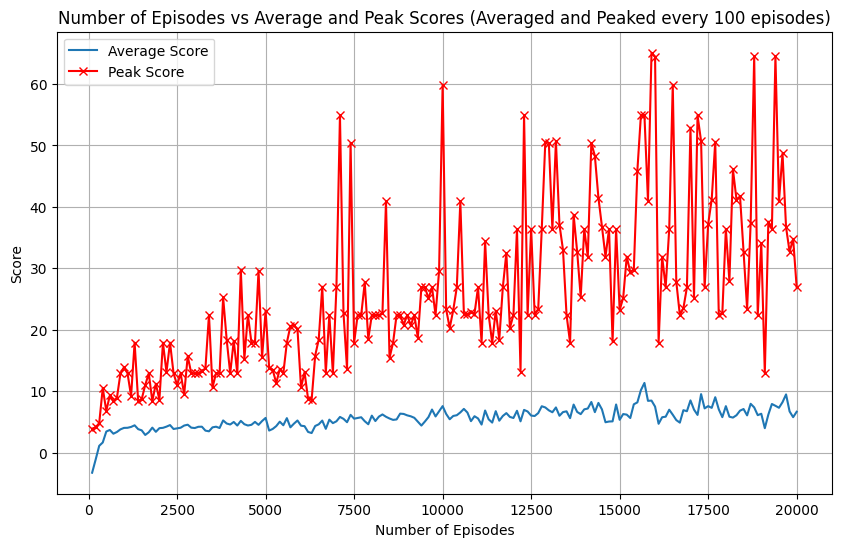

In [91]:
import csv
import matplotlib.pyplot as plt

# Function to read and parse the CSV file, compute average scores and peak scores every N episodes
def parse_csv_and_analyze(file_path, N):
    n_episodes = []
    avg_scores = []
    peak_scores = []
    
    with open(file_path, 'r') as csv_file:
        reader = csv.DictReader(csv_file)
        scores = []
        episode_count = 0
        for row in reader:
            episode_count += 1
            score = float(row['score'])
            scores.append(score)
            if episode_count % N == 0:
                avg_score = sum(scores) / N
                peak_score = max(scores)
                n_episodes.append(episode_count)
                avg_scores.append(avg_score)
                peak_scores.append(peak_score)
                scores = []
    
    # If there are remaining scores that didn't complete an N interval
    if scores:
        avg_score = sum(scores) / len(scores)
        peak_score = max(scores)
        n_episodes.append(episode_count)
        avg_scores.append(avg_score)
        peak_scores.append(peak_score)
    
    return n_episodes, avg_scores, peak_scores

# File path
csv_file_path = 'training_log.csv'
N = 100  # Change this to your desired interval for averaging and peak detection

# Parse the CSV file and compute averages and peaks
n_episodes, avg_scores, peak_scores = parse_csv_and_analyze(csv_file_path, N)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(n_episodes, avg_scores, linestyle='-', label='Average Score')
plt.plot(n_episodes, peak_scores, marker='x', linestyle='-', color='red', label='Peak Score')
plt.xlabel('Number of Episodes')
plt.ylabel('Score')
plt.title(f'Number of Episodes vs Average and Peak Scores (Averaged and Peaked every {N} episodes)')
plt.legend()
plt.grid(True)
plt.show()
